## Background:

Convolutional Neural Networks (CNNs) are fundamental to brain imaging. They function by applying a series of convolutional operations to an image.

CNNs apply this filtering operation repeatedly in varying sizes and formats, allowing the model to gain an *understanding* of the image. However, the complexity of the model increases substantially with the addition of more filters, leading to intensive memory and computational demands due to the vast complexity and numerous parameters [1].

A layer known as Max Pooling is incorporated into these networks. This layer maintains the same depth of the model while reducing its spatial size, thereby enhancing computational efficiency. It also preserves the key features of an image [2]. Several other layers are similarly employed to manage computation by adjusting either the depth or spatial size of the model.

It was however observed that some uncertainty propagates through the network using these techniques. For instance, assume the following 4x4 matrix:

$$
\begin{bmatrix}
7 & 7 \\
4 & 5
\end{bmatrix}
$$

A max pooling layer needs to choose which of the 7s to keep, and later, during upsampling, remember the index where the 7 was found. Different implementations can cause different issues.


Observations from Dr. Glatard's lab suggest that replacing such occurrences with NaN values could potentially improve computational speed during both training and inference, while preserving the accuracy of the model. The logic is that parts of images with redundant information (e.g., the background) could be disregarded during the convolutional operation, as image patches containing a high count of NaN values might be ignored. Likewise, this will solve the problem mentioned above. This is hypothesized to accelerate the calculations in convolutional operations.

A Python implementation of this NaN pooling has already been developed with success in the lab, which showed promising results. However, to fully harness the potential of this approach, it must be adapted to PyTorch's C/C++ framework.

Hence, the following project is proposed: Can a C/C++ PyTorch implementation of this solution improve the speed of inference and training of CNN models and prevent uncertainty propagation while conserving current accuracy benchmarks?

Let's take a look.

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import nan_cpp as nanCPP
import time
from nan_ops import NaNPool2d, NormalPool2d, NaNConv2d, NormalConv2d, NaNConv2dV2

FILENAME = "mri_data//sample_data//outp_bn3_1.pkl"
# Load the data from the pickle file
data = pickle.load(open(FILENAME, 'rb'))

if isinstance(data, tuple):
    a = data[0]
else:
    a = data

#declaring so can be used in plotting
torch.tensor

<function torch._VariableFunctionsClass.tensor>

# Comparison of different pooling operations

First, we begin with a C++ implementation which can be found under nan.cpp. It converts the custom NaN pooling classes into C++, to hopefully improve the speed of execution of these files (or, in the very least, improve the speed of further convolutional layers). This was built following C++ frontent Torch libraries that are found [here](https://pytorch.org/cppdocs/frontend.html).

C++ Pooling

In [2]:
%%timeit -o -n 1 -r 10
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 0.25, None)


1min 17s ± 9.59 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 1min 17s ± 9.59 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [3]:
cppTime = _

In [4]:
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 0.25, None)

Let's run the python pooling, nan_pooling and torch pooling to compare speeds.

Python Pooling

In [5]:
%%timeit -o -n 1 -r 10
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


2min 4s ± 18.3 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 2min 4s ± 18.3 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [6]:
pyTime = _

In [7]:
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Normal Pool

In [8]:
%%timeit -o -n 1 -r 10
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


36.2 s ± 758 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 36.2 s ± 758 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [9]:
normalTime = _

In [10]:
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Torch Pool

In [11]:
%%timeit -o -n 1 -r 10
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)


# plt.savefig('/workspace/output_comparison.png')  # Save the first plot

The slowest run took 6.64 times longer than the fastest. This could mean that an intermediate result is being cached.
3.63 ms ± 3.71 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 3.63 ms ± 3.71 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [12]:
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

In [13]:
torchTime = _

Visualizing the pooling

It's time to visualize the pooling. For reference here is the mapping between the different layers and their implementation.
- nanCPP.NaNPool2d -> NaN aware pooling built in *C++*
- NaNPool2d -> NaN aware pooling built in *Python*
- NormalPool2d -> NaN **un**aware pooling built in *Python*
- torch.nn.MaxPool2d -> NaN **un**aware pooling built in *PyTorch*

TODO: FIX PATCHES (NOT IMPORTANT ATM)

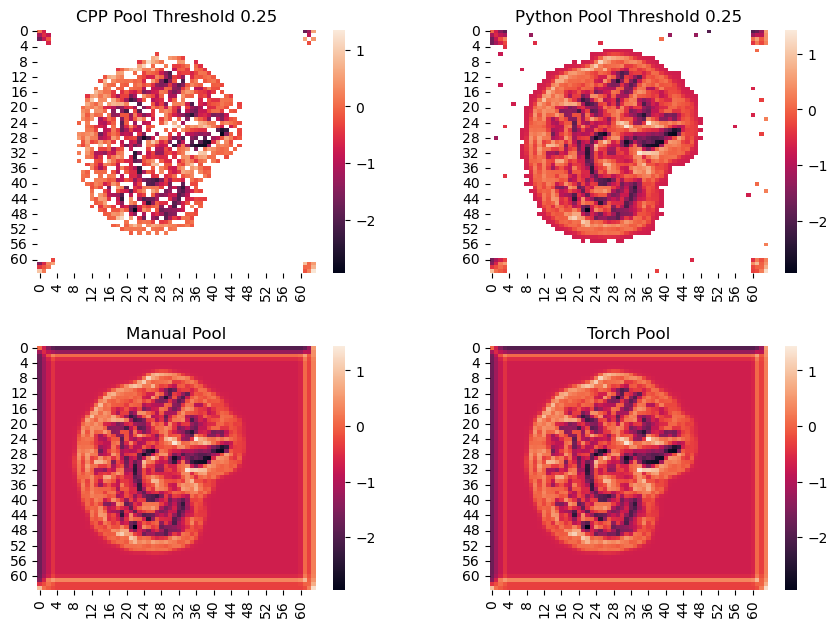

In [14]:
# Visualize output
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')
sns.heatmap(np.mean(nanoutputPy.detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')
sns.heatmap(np.mean(normaloutput.detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')
sns.heatmap(np.mean(torchoutput.detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Visualizing the difference between both

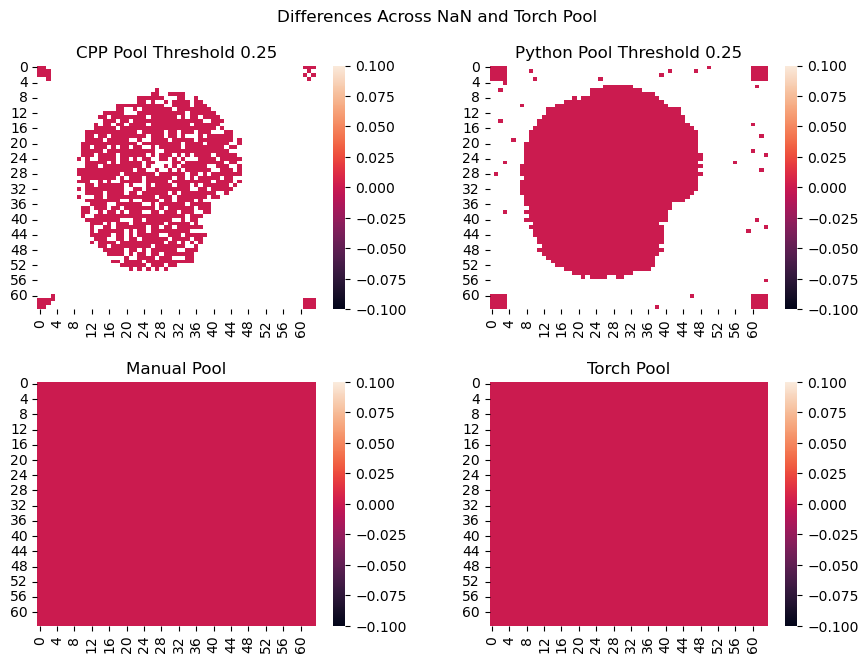

In [15]:
# %%timeit
# Visualize output differences -- should be 0
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Adjusted figure size for better layout

sns.heatmap(np.mean((nanoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')

sns.heatmap(np.mean((nanoutputPy - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')

sns.heatmap(np.mean((normaloutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')

sns.heatmap(np.mean((torchoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')

plt.suptitle('Differences Across NaN and Torch Pool')
# plt.savefig('/workspace/differences_comparison.png')  # Save the second plot
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Exploring the time taken for each method

In [16]:
cpp_time = cppTime.average
py_time = pyTime.all_runs
normal_time = normalTime.all_runs
torch_time = torchTime.all_runs

cpp_time

77.79103299860003

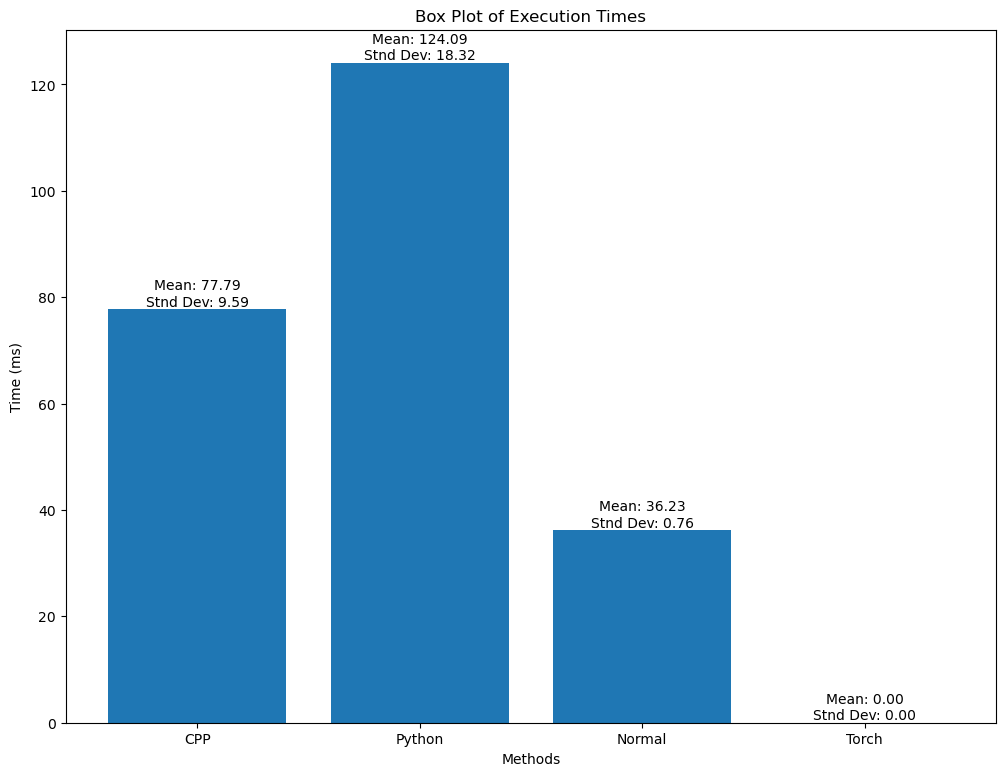

In [17]:
methods = ['CPP', 'Python', 'Normal', 'Torch']
times_objects = [cppTime, pyTime, normalTime, torchTime]

# Extracting the vectors from the time objects
cpp_time = cppTime.average
py_time = pyTime.average
normal_time = normalTime.average
torch_time = torchTime.average

# Extracting the standard deviations
cpp_std = cppTime.stdev
py_std = pyTime.stdev
normal_std = normalTime.stdev
torch_std = torchTime.stdev

times = [cpp_time, py_time, normal_time, torch_time]
times_stnd_dev = [cpp_std, py_std, normal_std, torch_std]

fig, ax = plt.subplots(figsize=(12, 9))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean, std_dev in zip(bars, times, times_stnd_dev):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}\nStnd Dev: {std_dev:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure

By observing the box plot, we notice a slight decrease in execution time between the Python and C++ implementations, as expected. Interestingly, the custom-written normal pooling method is faster than the NaN pooling method. This is expected because the computational speedup for NaN layers should be realized during the custom NaN convolution operation at the cost of a slower max pooling layer. NaNPooling involves additional comparisons to check for NaNs and duplicates, and to replace these values as necessary, which is not required in normal max pooling. However, during NaNConv, some convolutions should be skipped which should mean that we will see a faster execution time.

Given Torch's highly optimized code, matching its speed with our custom layers will be challenging. Notably, they can have different mathematical implementations (i.e., seperable filter, recursive convolution, using FFT [3]) or simply parallelizing the convolution operation [**source**]. However, if we can demonstrate that NaNPooling and NaNConv are faster than normal pooling and convolution, we can argue that NaN layers could outperform Torch's layers if subjected to the same level of optimization.

It can be observed that the improvement seen in our case reflect those found in pytorch's documentation found [here](https://pytorch.org/tutorials/advanced/cpp_extension.html). Their improvement takes about ~67% of the initial time whereas our takes about ~62% of our initial time. 

Documentation Example:
- Python custom implementation `Forward: 506.480 us | Backward 444.694 us`
- C++ custom implementation `Forward: 349.335 us | Backward 443.523 us`

NaN Pooling
- Python custom implementation `NaNPooling: 90.35 sec`
- C++ custom implementation `NaNPooling: 56.21 sec`

# Different Scenarios

It is observed that the threshold behaves a little differently in C++ than in the Python custom NaN implementation. Below is looking at it for different thresholds.

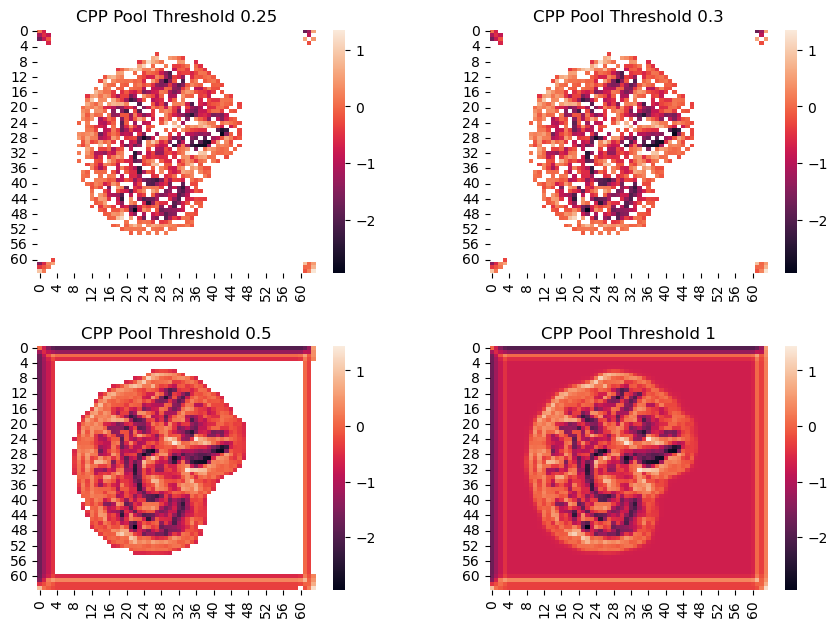

In [18]:
thresholds = [0.25, 0.30, 0.50, 1]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

for count, threshold in enumerate(thresholds):
    x = count // 2
    y = count % 2
    nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), threshold, None)
    sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[x][y])
    axes[x][y].set_title('CPP Pool Threshold ' + str(threshold))

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

# Exploring NaNConv in Python vs Normal NanConv

In [19]:
kernel = torch.randint(1,10,(2,71,6,6)).float()

In [20]:
%%timeit -o -n 1 -r 10
normalConv = NormalConv2d(kernel_size = (3,3), kernel = kernel, padding = 0)
normaloutput =  normalConv(a)  # pool_size == kernel_size


4.57 s ± 265 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 4.57 s ± 265 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [21]:
saved_time_Normal = _
saved_time_Normal = saved_time_Normal.average

In [22]:
%%timeit -o -n 1 -r 10
nanConv = NaNConv2d(kernel_size = (3,3), kernel = kernel, padding = 1, threshold = 1)
nanoutput = nanConv(a)

6.35 s ± 444 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 6.35 s ± 444 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [23]:
saved_time_Nan = _
saved_time_Nan = saved_time_Nan.average

In [24]:
%%timeit -o -n 1 -r 10
nanConv = NaNConv2d(kernel_size = (3,3), kernel = kernel, padding = 1, threshold = 1)
nanoutput = nanConv(a)

6.3 s ± 457 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 6.3 s ± 457 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [25]:
saved_time_NanV2 = _
saved_time_NanV2 = saved_time_NanV2.average

In [26]:
%%timeit -o -n 1 -r 10
torchConv = torch.nn.Conv2d(71, 2, 3, padding=1)
torchoutput = torchConv(a)

The slowest run took 4.11 times longer than the fastest. This could mean that an intermediate result is being cached.
4.15 ms ± 2.62 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 4.15 ms ± 2.62 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [27]:
saved_time_torch = _
saved_time_torch = saved_time_torch.average

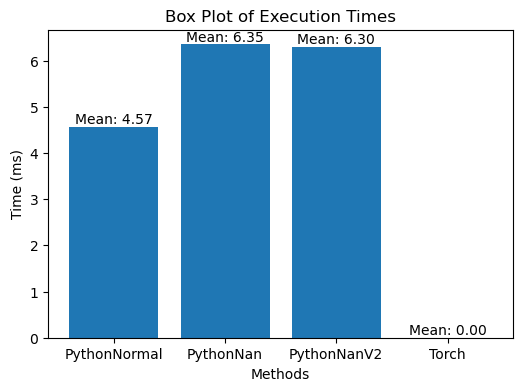

In [28]:
methods = ['PythonNormal', 'PythonNan', 'PythonNanV2', 'Torch']
times = [saved_time_Normal, saved_time_Nan, saved_time_NanV2,  saved_time_torch]

fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure

The observed results suggest that pythonNormal outperforms PythonNAN in terms of speed. Initially, it was hypothesized that the presence of numerous NaNs in the image background would accelerate the convolution process. However, this does not appear to be the case. It's plausible that the overhead incurred by checking for NaNs negates any potential speed benefits. This could be attributed to two factors:

- There might be a minor speed advantage when checking for NaNs, but it's likely so marginal that it's offset by the overhead introduced when convolutions occur in areas without NaNs. This overhead could counterbalance any time saved or advantages gained from the NaNs earlier in the process.
- There is no computational speedup and the checking just adds unnecessary overhead. 

## Works Cited:

[1] Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. J Big Data 8, 53 (2021). https://doi.org/10.1186/s40537-021-00444-8

[2] Zhao, L., Zhang, Z. A improved pooling method for convolutional neural networks. Sci Rep 14, 1589 (2024). https://doi.org/10.1038/s41598-024-51258-6

[3] **TODO** https://scicomp.stackexchange.com/questions/10356/computational-complexity-of-2d-convolution